In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from cellfate import model, io, celldensity
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op

## The Data

This package accepts data in the form of csv files outputed by the CellProfiler Software available from MIT's Broad Institute (cellprofiler.org). 

The example data used here is processed time-lapse images of differentiating stem cells with tagged transcription factors.

![t1](t1.png)

The example cells are embryonic stem cells modified using CRISPR so as to create two tagged transcription factors: Oct4-mCherry and Sox2-GFP. These show up respectively in the red and green channels of our time lapse image set. Above is a composite image of the starting time point. Green cells become neurectoderm (Sox2 only), and red cells become mesendoderm (Oct4 only). 

CellProfiler can then be used to segment images and classify cells by relative color. A segmented version of the above image is shown below.

![t1-segmented](t1-segmented.png)

In this sample, cells were classified using the upper quartile intensity of each identified nuclei. The yellow color indicated red-dominated cells, the aqua indicates green-dominated, and navy and burgandy indicate the undifferentiated "both" cell state. 

![t1-classified](t1-classified.png)

CellProfiler was then used to export the nuclear locations and classifications to a csv file. Our package is configured to read these default-configured CellProfiler output CSV files (created using the ExportToSpreadsheet analysis module).

The images shown above are for the first of 175 time steps in our sample data set. 

### Data Import

Data is imported from CSV files. The classification was done using the upper quartile intensity of each segmented cell. This is accessed in the function cell_density_fun.py. 

We can read in data using io.read.

In [2]:
data=io.read('full-data.csv', 'Sox2', 'Oct4', 4)

This gives us a cell density object. This object is essentially a pandas data frame with some additional meta-data.

    our_data.data['Oct4']
    our_data.data['Sox2']
    our_data.data['Both']
    
Gives the data for each cell type over time. The other properties are bin_num, cellname, and tot_time.

In [22]:
our_data.plotMap()

### Inference

#### Model
Firstly, model should be specified in the function "diffeq" of model.py. Currently, the model is generated with the following system of differential equations:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + k_{b\rightarrow g } n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + k_{b\rightarrow r } n_{r}(t,x,y) $$

In [4]:
def diffeq(w, t, p):
    """
    Defines the differential equations for our model.

    Arguments:
        w :  vector of the state variables:
                  w = [red, grn, both]
        t :  time
        p :  vector of the parameters:
                  p = [k_div, k_bg, k_br]
    """
    grn, red, both = w
    k_div, k_bg, k_br = p

    # Create f = (red,grn,both) - order should be same as in w vector:
    f = [k_div*grn + k_bg*both,
         k_div*red + k_br*both,
         k_div*both - (k_bg+k_br)*both]

    return f

#### MCMC Run

With the created celldensity object, we can run MCMC by using the model module.

In [6]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(data, 1000))

print(res)

Optimization terminated successfully.
         Current function value: 65838.263699
         Iterations: 109
         Function evaluations: 204
[  1.54669528e-10   6.96645013e-01   6.88803015e-01]


In [8]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(data, 1000))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 58.2 s, sys: 306 ms, total: 58.5 s
Wall time: 59.2 s
Done


#### Visualizing MCMC run

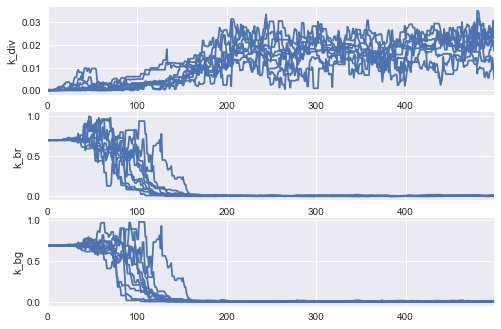

In [9]:
# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_br.set(ylabel='k_br')
ax_k_bg.set(ylabel='k_bg')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_bg)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


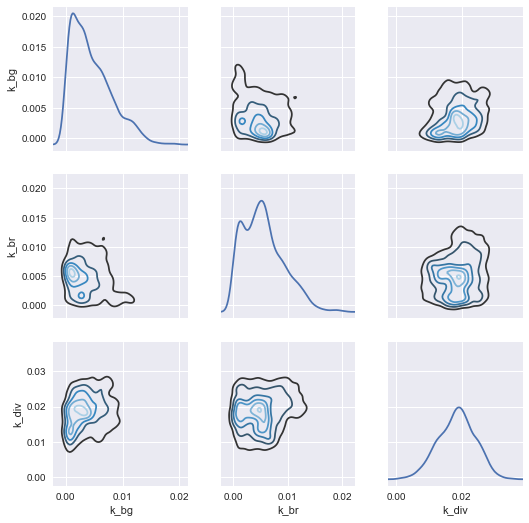

In [10]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_br': traces[1], 'k_bg': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);